In [75]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import zipfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

from skimage import color, io
from scipy.misc import imresize

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.utils import np_utils


np.random.seed(31337)

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
# Read preds 
from six.moves import cPickle as pickle
pickle_file = 'catfish.pickle'

def unpickle(pickle_file):
    try:
        with open(pickle_file) as f:
            data=pickle.load(f)
    except Exception as e:
      print('Unable to load data from', pickle_file, ':', e)
      raise
    return data


In [3]:
# Read labels

save=unpickle('catfish.pickle')
train_images_sane=save['train_images_sane']
train_images=save['train_images']
insane_indices=save['insane_indices']
test_images=save['test_images']


In [4]:
# ResNet50 preds

X_train_ResNet50=unpickle('ResNet50_train_preds.pickle')
X_verify_ResNet50=unpickle('ResNet50_verify_preds.pickle')
#X_test_ResNet50=unpickle('ResNet50_test_preds.pickle')

# Squeeznet preds
X_train_squeezenet=unpickle('squeezenet_train_preds.pickle')
X_verify_squeezenet=unpickle('squeezenet_verify_preds.pickle')
#X_test_squeezenet=unpickle('squeezenet_test_preds.pickle')

In [5]:
# Build labels

Y_train = np.array([int('dog' in train_images_sane[i]) for i in xrange(len(train_images_sane))])

Y_verify = np.array([int('dog' in train_images[i]) for i in insane_indices])


Y_train = np_utils.to_categorical(Y_train, 2)
Y_verify = np_utils.to_categorical(Y_verify, 2)

In [65]:
# Build model_ResNet50

model_ResNet50 = Sequential()
model_ResNet50.add(Dense(128, input_dim=1000, init='uniform', activation='relu'))
#model_ResNet50.add(Dropout(0.25))
model_ResNet50.add(Dense(32, init='uniform', activation='relu'))
model_ResNet50.add(Dropout(0.5))
model_ResNet50.add(Dense(1, init='uniform', activation='sigmoid'))

# Compile model_ResNet50
model_ResNet50.compile(loss='binary_crossentropy', optimizer='adam') #, metrics=['accuracy']) # LOSS!!!

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


In [ ]:
# Fit ResNet50 the model 
history = model_ResNet50.fit(X_train_ResNet50, Y_train, 
                             #validation_data=(X_verify_ResNet50, Y_verify),
                             validation_split=0.33, 
                             nb_epoch=150, batch_size=500, 
                             callbacks=[early_stop],
                             verbose=0)
# list all data in history
print(history.history.keys())

In [17]:
score_test = model_ResNet50.evaluate(X_train_ResNet50, Y_train, verbose=0)

print (score_test)

#print("%s: %.2f%%" % (model_ResNet50.metrics_names[1], score_test[1]*100))

score_valid = model_ResNet50.evaluate(X_verify_ResNet50, Y_verify, verbose=0)

print (score_valid)

#print("%s: %.2f%%" % (model_ResNet50.metrics_names[1], score_valid[1]*100))


0.0658812005903
0.326877725585


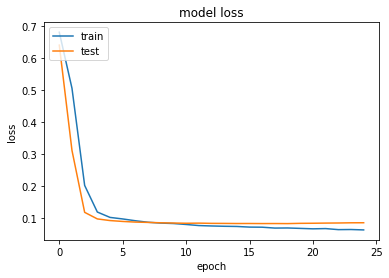

In [13]:
# # summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [123]:
# Build model_squeezenet

model_squeezenet = Sequential()
model_squeezenet.add(Dense(50, input_dim=1000, activation='relu',init='uniform'))
model_squeezenet.add(Dropout(0.1))
model_squeezenet.add(Dense(10, activation='relu',init='uniform'))
model_squeezenet.add(Dropout(0.1))
model_squeezenet.add(Dense(10, activation='tanh',init='uniform'))
model_squeezenet.add(Dense(2, activation='softmax',init='uniform'))

# model_squeezenet = Sequential()
# model_squeezenet.add(Dense(12000, input_dim=1000, init='uniform', activation='relu'))
# model_squeezenet.add(Dropout(0.9))
# model_squeezenet.add(Dense(10000, init='uniform', activation='relu'))
# model_squeezenet.add(Dropout(0.9))
# model_squeezenet.add(Dense(1000, init='uniform', activation='relu'))
# model_squeezenet.add(Dropout(0.8))
# model_squeezenet.add(Dense(1, init='uniform', activation='sigmoid'))

# Compile model_squeezenet
model_squeezenet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

model_squeezenet.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_128 (Dense)                (None, 50)            50050       dense_input_33[0][0]             
____________________________________________________________________________________________________
dropout_81 (Dropout)             (None, 50)            0           dense_128[0][0]                  
____________________________________________________________________________________________________
dense_129 (Dense)                (None, 10)            510         dropout_81[0][0]                 
____________________________________________________________________________________________________
dropout_82 (Dropout)             (None, 10)            0           dense_129[0][0]                  
___________________________________________________________________________________________

In [124]:
# Fit squeezenet the model 
history = model_squeezenet.fit(X_train_squeezenet, Y_train, 
                             #validation_data=(X_verify_squeezenet, Y_verify),
                             validation_split=0.33, 
                             nb_epoch=200, batch_size=500, 
                             callbacks=[early_stop],
                             verbose=0)
# list all data in history
print(history.history.keys())

Epoch 00031: early stopping
['acc', 'loss', 'val_acc', 'val_loss']


In [125]:
score_test = model_squeezenet.evaluate(X_train_squeezenet, Y_train, verbose=0)

print("%s: %.2f%%" % (model_squeezenet.metrics_names[1], score_test[1]*100))

score_valid = model_squeezenet.evaluate(X_verify_squeezenet, Y_verify, verbose=0)

print("%s: %.2f%%" % (model_squeezenet.metrics_names[1], score_valid[1]*100))


acc: 96.21%
acc: 89.29%


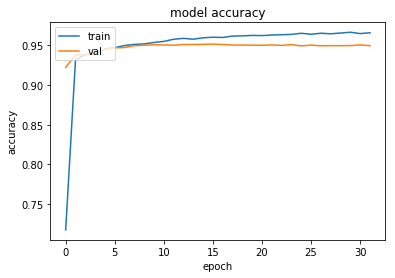

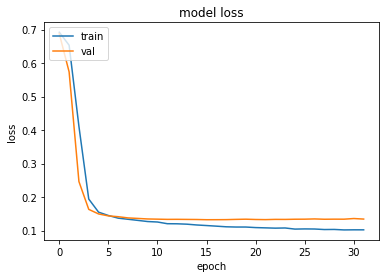

In [126]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [44]:
X_test_ResNet50=unpickle('ResNet50_test_preds.pickle')
X_test_squeezenet=unpickle('squeezenet_test_preds.pickle')

Y_test_squeezenet=model_squeezenet.predict(X_test_squeezenet)
Y_test_ResNet50=model_ResNet50.predict(X_test_squeezenet)

NameError: name 'model_ResNet50' is not defined

In [45]:
plt.hist(Y_test_ResNet50, bins='auto', log=True) 
plt.title("Aspect ratio Histogram (log scale)")
plt.show()

plt.hist(Y_test_squeezenet, bins='auto', log=True) 
plt.title("Aspect ratio Histogram (log scale)")
plt.show()

NameError: name 'Y_test_ResNet50' is not defined

In [59]:
import re
test_ids=[re.split('/|\.',i)[1] for i in test_images]

In [60]:
Y_test_ResNet50_csv=np.column_stack((test_ids,Y_test_ResNet50))
Y_test_squeezenet_csv=np.column_stack((test_ids,Y_test_squeezenet))


In [61]:
np.savetxt('Y_test_ResNet50.csv',Y_test_ResNet50_csv, fmt="%s,%s", header=("id,label"),comments='')
np.savetxt('Y_test_squeezene.csv',Y_test_squeezenet_csv, fmt="%s,%s", header=("id,label"),comments='')